In [146]:
#|default_exp plots
#|export
import numpy as np
import pandas as pd
import os
from fastcore.all import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tsai.basics import *

# Data Plotters

In this notebook, we implement some of the plots that are used across several notebooks. If a plot is not used frequently, we implement it directly in the desired notebook to keep things simple.

## Index/Activity Level-wise Performance Plot

The `plot_solar_algorithm_performance()` function creates a grid of plots to visualize the forecast error of solar activity levels across different error types (percent and sfu). Each row corresponds to a **solar activity level** (low, moderate, elevated, high), and each column represents an **error type**. The function displays the **mean error** with a shaded region representing the **standard deviation** for each day from the epoch, providing a comprehensive view of forecasting performance for a specific variable.


In [147]:
#|export

def plot_solar_algorithm_performance(df, var, figsize=(10, 10), ylims=None):
    # Plot a grid where each row is a solar activity level, and each column
    # is a error type (sfu or percent). Each cell is the result of calling the 
    # function plot_fe.
    # Input:
    # df: dataframe with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, mean_sfu, std_sfu, mean_percent, std_percent
    # var: variable to plot (F10, S10, M10, Y10)
    # figsize: figure size
    # ylims_mean: List with the y limits of the mean for each error type: 
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # ylims_std: List with the y limits of the standard deviation for each error type:
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # Output:
    # None, but it plots the grid
    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent', 'sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            # Minimum and maximum values across column
            min_val = df[f'mean_{err_type}'].min() - np.abs(df[f'std_{err_type}'].max()) if ylims is None else ylims[idx][0]
            max_val = df[f'mean_{err_type}'].max() + np.abs(df[f'std_{err_type}'].max()) if ylims is None else ylims[idx][1]


            mean_fe = df_var[f'mean_{err_type}'].values
            std_fe = df_var[f'std_{err_type}'].values
            ax = axs[sal_idx, idx]
            p1 = ax.plot(mean_fe, color='#000000', label='Mean')
            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')
            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val, max_val)
            ax.set_yticks(np.arange(-20, 21, 5))
            ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe), mean_fe + np.abs(std_fe), color='red', alpha=0.2)

            p2 = ax.fill(np.NaN, np.NaN, 'red', alpha=0.5)
            ax.legend([p1[0], p2[0]], ['Mean Error', '[STDE]'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=True)
            
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts', pad=15)
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

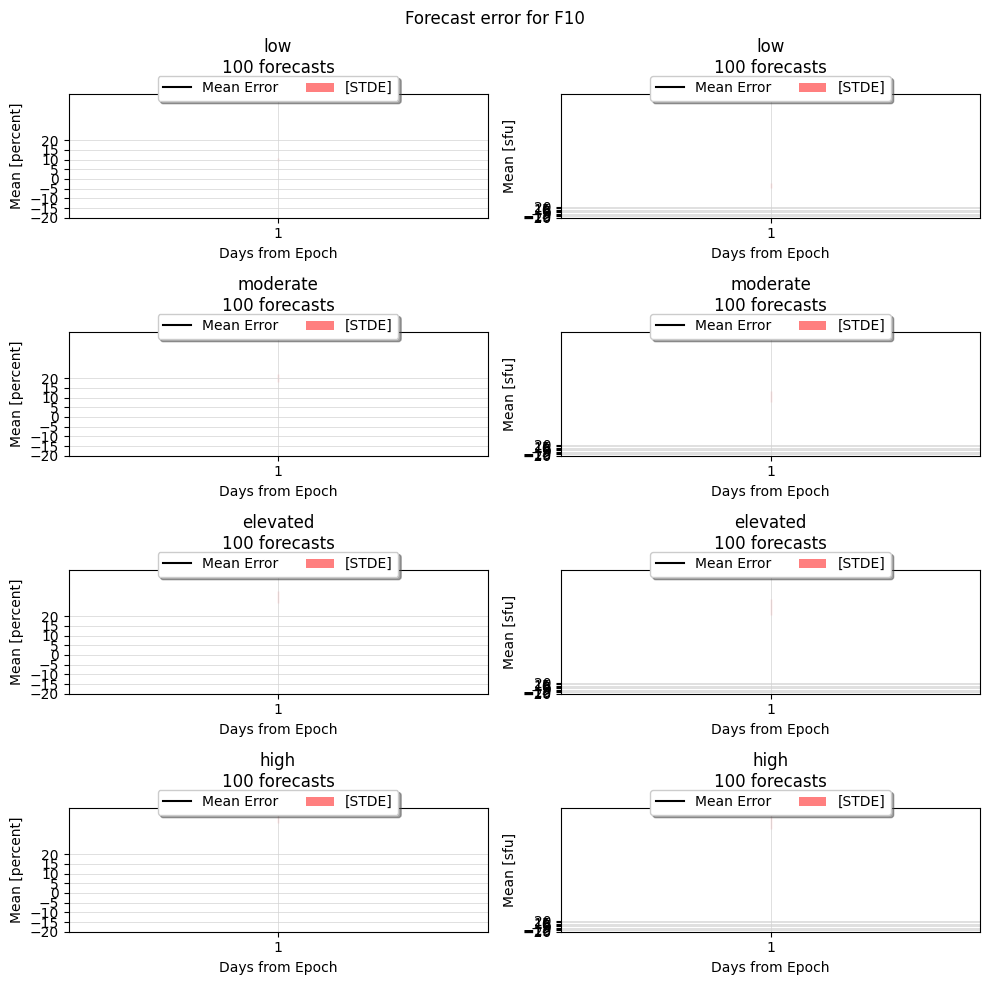

In [148]:
# Test 
df = pd.DataFrame({'variable': ['F10', 'F10', 'F10', 'F10', 'S10', 'S10', 'S10', 'S10'],
                   'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
                   'horizon': [1, 1, 1, 1, 1, 1, 1, 1],
                   'n_samples': [100, 100, 100, 100, 100, 100, 100, 100],
                   'mean_percent': [10, 20, 30, 40, 10, 20, 30, 40],
                   'std_percent': [1, 2, 3, 4, 1, 2, 3, 4],
                   'mean_sfu': [100, 200, 300, 400, 100, 200, 300, 400],
                   'std_sfu': [10, 20, 30, 40, 10, 20, 30, 40]})
plot_solar_algorithm_performance(df, 'F10', figsize=(10, 10))

## Solar Indices Forecasting Model Comparison Plot

The `plot_solar_algorithm_performance_comparison()` function compares forecast error metrics between two datasets for a given variable across different solar activity levels (low, moderate, elevated, high). It generates a grid of subplots, with each row representing a **solar activity level** and each column representing an **error type** (percent and sfu). The function overlays the **main dataset** with a **benchmark dataset**, adjusts y-limits, annotates subplots with sample sizes, and includes a legend and grid for clarity.


### Individual comparison

In [149]:
#|export
def plot_solar_algorithm_performance_comparison(df, df_paper, var, figsize=(10, 10), ylims=None):
    """
    Plots and compares forecast error metrics from two datasets for a given variable across different solar activity levels.

    Parameters:
    - df (DataFrame): Main dataset containing error metrics and sample counts.
    - df_paper (DataFrame): Benchmark dataset for comparison.
    - var (str): Variable of interest (e.g., temperature).
    - figsize (tuple): Dimensions of the figure (width, height).
    - ylims (list of tuples): Optional y-axis limits for each plot; defaults to auto-calculated based on data.

    This function creates a grid of subplots for each solar activity level, comparing two error types. 
    It adjusts y-limits, annotates subplots with sample sizes, and adds a legend and grid for clarity.
    """

    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent','sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            df_paper_var = df_paper[(df_paper['variable'] == var) & (df_paper['condition'] == sal)]

            # Minimum and maximum values across column
            min_val = df_var[f'mean_{err_type}'].min() - np.abs(df_var[f'std_{err_type}'].max()) if ylims is None else ylims[idx][0]
            max_val = df_var[f'mean_{err_type}'].max() + np.abs(df_var[f'std_{err_type}'].max()) if ylims is None else ylims[idx][1]
            
            min_val_paper = df_paper_var[f'mean_percent'].min() - np.abs(df_paper_var[f'std_percent'].max()) if ylims is None else ylims[idx][0]
            max_val_paper = df_paper_var[f'mean_percent'].max() + np.abs(df_paper_var[f'std_percent'].max()) if ylims is None else ylims[idx][1]
            
            if np.isnan(min_val) or np.isnan(max_val):
                min_val = min_val_paper
                max_val = max_val_paper
            
            min_val = min(min_val, min_val_paper)
            min_val = int(min_val) - (int(min_val)%10)
            max_val = max(max_val, max_val_paper)
            max_val = int(max_val) + (10 - int(max_val)%10)

            mean_fe = df_var[f'mean_{err_type}'].values
            mean_fe_paper = df_paper_var[f'mean_{err_type}'].values
            std_fe = df_var[f'std_{err_type}'].values
            std_fe_paper = df_paper_var[f'std_{err_type}'].values 
            ax = axs[sal_idx, idx]
            p1 = ax.plot(mean_fe, color='#c00000')
            p3 = ax.plot(mean_fe_paper, color='#572364')

            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')

            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val, max_val)
            steps = (max_val-min_val)/10
            ax.set_yticks(np.arange(min_val, max_val,steps))
            ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe),
                            mean_fe + np.abs(std_fe),
                            color='#ff8000', alpha=0.3)

            ax.fill_between(range(len(mean_fe_paper)), mean_fe_paper - np.abs(std_fe_paper),
                            mean_fe_paper + np.abs(std_fe_paper),
                            color='#9a2edb', alpha=0.2)

            
            p2 = ax.fill(np.NaN, np.NaN, '#ff8000', alpha=0.3)
            p4 = ax.fill(np.NaN, np.NaN, '#9a2edb', alpha=0.2)

            ax.legend([(p1[0], p2[0]),(p3[0], p4[0])],
                        ['Mean Error[STDE]', 'Mean Error (Benchmark) [STDE]'], 
                        loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, 
                        fancybox=True, shadow=True)

            
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts', pad=15)
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

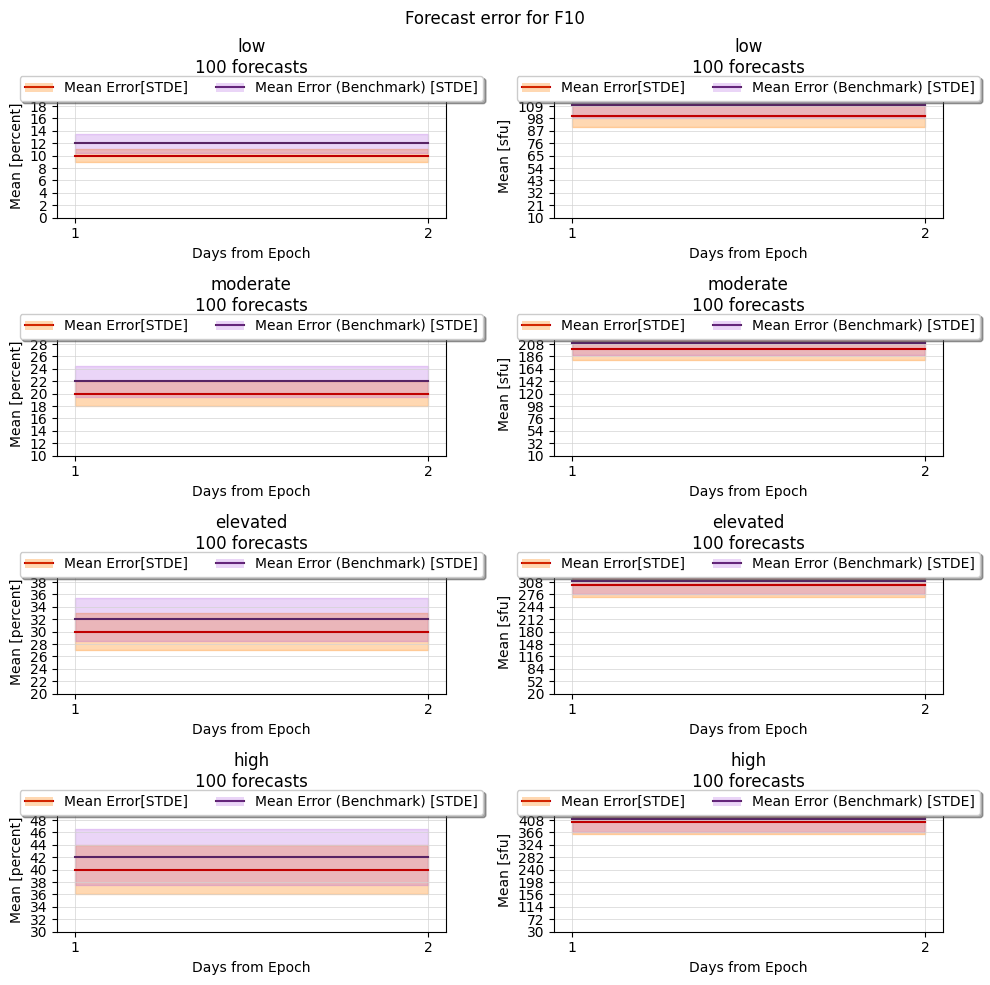

In [150]:
# Test

# Sample DataFrames to test the plotting function
df_main = pd.DataFrame({
    'variable': ['F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10'],
    'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
    'horizon': [1, 2, 3, 4, 5, 6, 7, 8],
    'n_samples': [100, 100, 100, 100, 100, 100, 100, 100],
    'mean_percent': [10, 20, 30, 40, 10, 20, 30, 40],
    'std_percent': [1, 2, 3, 4, 1, 2, 3, 4],
    'mean_sfu': [100, 200, 300, 400, 100, 200, 300, 400],
    'std_sfu': [10, 20, 30, 40, 10, 20, 30, 40]
})

df_paper = pd.DataFrame({
    'variable': ['F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10'],
    'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
    'horizon': [1, 2, 3, 4, 5, 6, 7, 8],
    'n_samples': [100, 100, 100, 100, 100, 100, 100, 100],
    'mean_percent': [12, 22, 32, 42, 12, 22, 32, 42],
    'std_percent': [1.5, 2.5, 3.5, 4.5, 1.5, 2.5, 3.5, 4.5],
    'mean_sfu': [110, 210, 310, 410, 110, 210, 310, 410],
    'std_sfu': [12, 22, 32, 42, 12, 22, 32, 42]
})

# Call the plotting function with test data
plot_solar_algorithm_performance_comparison(df_main, df_paper, 'F10', figsize=(10, 10))


### General Comparison

In [151]:
#| export
def plot_solar_algorithm_performance_all_indices(df, df_paper, figsize=(40, 15), ylims=None, save_fig=False):
    # Plot a grid where each row is a solar activity level, and each column is a variable.
    # Each cell contains the percent error comparison.
    # Input:
    # df: DataFrame with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, mean_percent, std_percent
    # df_paper: DataFrame with the results from the paper for comparison
    # figsize: figure size
    # ylims: List with the y limits for percent error: [(percent_min, percent_max)]
    # Output: None, but it plots the grid
    
    sals = ['low', 'moderate', 'elevated', 'high']
    vars = ['F10', 'S10', 'M10', 'Y10']
    
    fig, axs = plt.subplots(len(sals), len(vars), figsize=figsize)
    
    for sal_idx, sal in enumerate(sals):
        for var_idx, var in enumerate(vars):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            df_paper_var = df_paper[(df_paper['variable'] == var) & (df_paper['condition'] == sal)]

            # Determine min and max values for y-axis
            min_val = df_var['mean_percent'].min() - np.abs(df_var['std_percent'].max()) if ylims is None else ylims[0][0]
            max_val = df_var['mean_percent'].max() + np.abs(df_var['std_percent'].max()) if ylims is None else ylims[0][1]
            
            min_val_paper = df_paper_var['mean_percent'].min() - np.abs(df_paper_var['std_percent'].max()) if ylims is None else ylims[0][0]
            max_val_paper = df_paper_var['mean_percent'].max() + np.abs(df_paper_var['std_percent'].max()) if ylims is None else ylims[0][1]
            
            min_val = min(min_val, min_val_paper)
            min_val = int(min_val) - (int(min_val)%10)
            max_val = max(max_val, max_val_paper)
            max_val = int(max_val) + (10 - int(max_val)%10)

            mean_fe = df_var['mean_percent'].values
            mean_fe_paper = df_paper_var['mean_percent'].values
            std_fe = df_var['std_percent'].values
            std_fe_paper = df_paper_var['std_percent'].values 
            
            ax = axs[sal_idx, var_idx]
            p1, = ax.plot(mean_fe, color='#c00000', lw=2.7)
            p2, = ax.plot(mean_fe_paper, color='#572364', lw=2.7)

            if sal_idx == len(sals) - 1:
                ax.set_xlabel('Days from Epoch', fontsize=18)
            if var_idx == 0:
                ax.set_ylabel(f'Error [%]', color='#000000', fontsize=18)

            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1), fontsize=14)
            ax.set_ylim(min_val, max_val)
            steps = (max_val - min_val) / 10
            ax.set_yticks(np.arange(min_val, max_val, steps))
            ax.set_yticklabels(np.arange(min_val, max_val, steps), fontsize=14)
            p3 = ax.fill_between(range(len(mean_fe)), mean_fe - np.abs(std_fe),
                            mean_fe + np.abs(std_fe),
                            color='#ff8000', alpha=0.3)

            p4 = ax.fill_between(range(len(mean_fe_paper)), mean_fe_paper - np.abs(std_fe_paper),
                            mean_fe_paper + np.abs(std_fe_paper),
                            color='#9a2edb', alpha=0.2)

            n_samples = df_var['n_samples'].values[0] 
            if sal_idx == 0:
                ax.set_title(f'{var}.7' , fontweight='bold', fontsize=26, pad=35)
       
            ax.text(0, max_val - steps, f'{n_samples} forecasts', fontsize=12, fontstyle='italic')
            ax.text(2.5, max_val + 1, f'{sal.capitalize()} Solar Activity', fontsize=20, fontstyle='italic', ha='center', )



            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)

    # Create a single legend at the bottom
    example_mean = ax.plot([], [], color='grey', lw=2.5, label='Mean')[0]
    example_std = ax.fill_between([], [], [], color='grey', alpha=0.3)

    # Combine handles and labels
    handles_example = [example_mean, example_std]
    labels_example = ['Mean', 'STD']
    measures_legend = fig.legend(handles_example, labels_example, 
                                loc='upper center', ncol=1, 
                                fancybox=True, shadow=True, fontsize=18, 
                                bbox_to_anchor=(0.47, 0.06), title='Measures'
                                )
    measures_legend.get_title().set_fontsize('14')

    handles = [(p1, p3), (p2, p4)]
    labels = ['PatchTST', 'SOLAR2000']

    algorithm_legend = fig.legend(handles, labels, 
                                  loc='lower center', ncol=1, 
                                  fancybox=True, shadow=True, fontsize=18, 
                                  bbox_to_anchor=(0.53, -0.032), title='Forecast Models'
                                  )
    algorithm_legend.get_title().set_fontsize('14')
    plt.subplots_adjust(hspace=0.3) 

    if save_fig:
        plt.savefig('figures/solfsmy_comparison.png', format='png', bbox_inches='tight', dpi=300)

    plt.show()

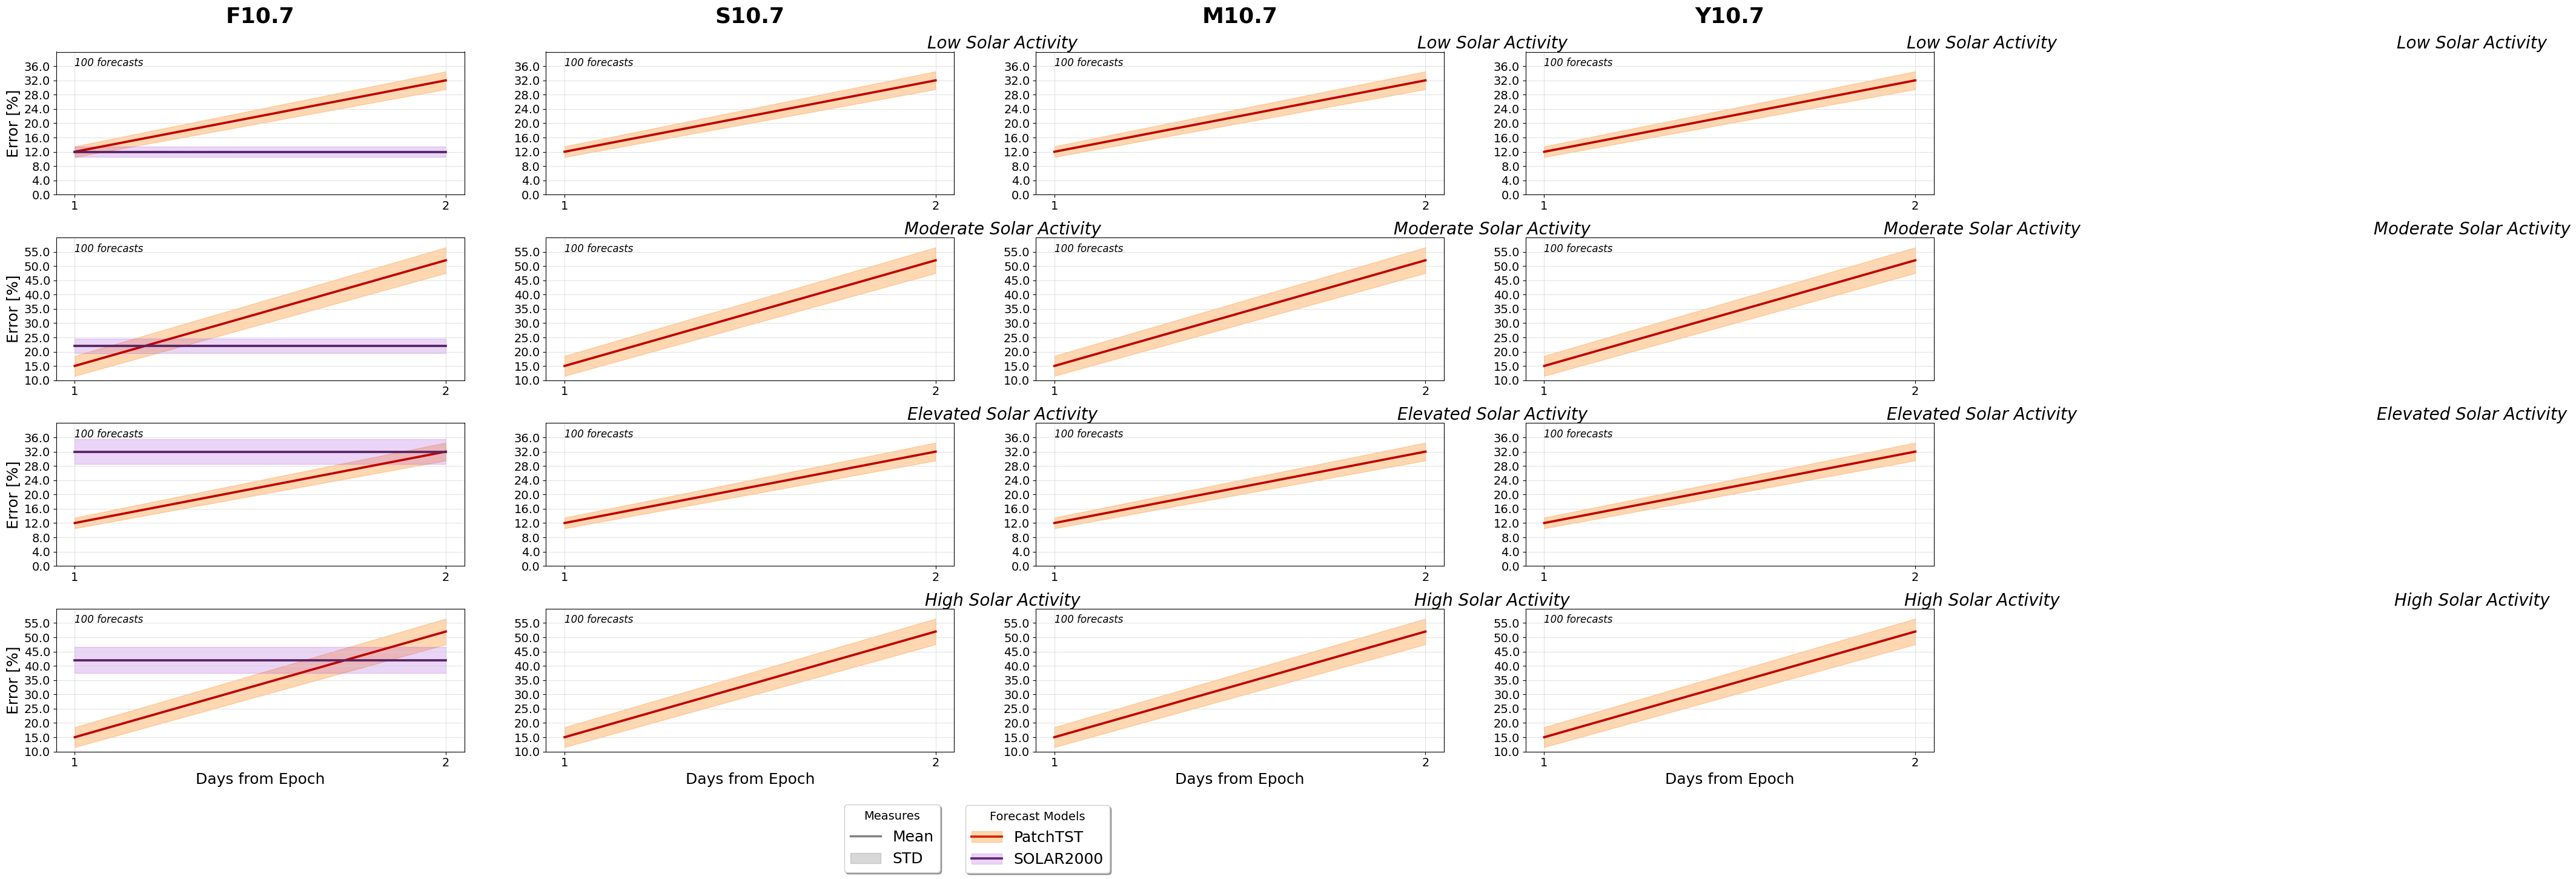

In [152]:
# Corrected Test DataFrames
df_main = pd.DataFrame({
    'variable': ['F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 
                 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10'],
    'condition': ['low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high'],
    'horizon': [2, 3] * 16,
    'n_samples': [100] * 32,
    'mean_percent': [12, 22, 32, 42] * 8,
    'std_percent': [1.5, 2.5, 3.5, 4.5] * 8,
    'mean_sfu': [110, 210, 310, 410] * 8,
    'std_sfu': [12, 22, 32, 42] * 8
})

df_main = pd.DataFrame({
    'variable': ['F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'F10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 'S10', 
                 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'M10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10', 'Y10'],
    'condition': ['low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high', 
                  'low', 'low', 'moderate', 'moderate', 'elevated', 'elevated', 'high', 'high'],
    'horizon': [2, 3] * 16,
    'n_samples': [100] * 32,
    'mean_percent': [12, 32, 15, 52] * 8,
    'std_percent': [1.5, 2.5, 3.5, 4.5] * 8,
    'mean_sfu': [110, 210, 310, 410] * 8,
    'std_sfu': [12, 22, 32, 42] * 8
})

# Call the plotting function with the corrected test data
plot_solar_algorithm_performance_all_indices(df_main, df_paper)


## Predictions Performance

The `plot_predictions_performance` function visualizes the performance of predicted values against true values across multiple columns in a dataset. It creates subplots where each plot compares the true and predicted values for a specific column, highlighting overestimations in red and underestimations in blue. The function also annotates the points with their values and adjusts date formatting on the x-axis if the data is daily or hourly. This provides a clear visual comparison of prediction accuracy.

In [153]:
#| export
def plot_predictions_performance(true_df, preds_df, data_columns):
    """
    Plot the performance of the predictions compared to the true values.
    
    Parameters
    ----------
    true_df : pd.DataFrame
        DataFrame containing the true values.
    preds_df : pd.DataFrame
        DataFrame containing the predicted values
    """
    true_df = true_df.copy()
    preds_df = preds_df.copy()

    # Align preds_df with true_df by setting Date as index in true_df
    true_df.set_index('Datetime', inplace=True)

    # Assuming preds_df has the same index as true_df (if not, align them accordingly)
    preds_df.index = true_df.index

    # Number of columns to plot
    num_columns = len(data_columns)
    num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows), sharex=True)
    axes = axes.flatten()  # Flatten in case there is a single row

    # Plot each column
    for i, column in enumerate(data_columns):
        ax = axes[i]
        
        # Plot true values with points
        ax.plot(true_df.index, true_df[column], label='True', color='black', marker='o')
        
        # Plot predicted values with points
        ax.plot(preds_df.index, preds_df[column], label='Predicted', color='green', marker='o')
        
        # Add ribbon
        overestimate = preds_df[column] > true_df[column]
        underestimate = preds_df[column] <= true_df[column]
        
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=overestimate, facecolor='red', alpha=0.2, interpolate=True, label='Overestimated')
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=underestimate, facecolor='blue', alpha=0.2, interpolate=True, label='Underestimated')
        
        # Annotate points with values
        for x, y in zip(true_df.index, true_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)
        for x, y in zip(preds_df.index, preds_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)

        ax.set_title(f'Comparison of true and predicted values for {column}')
        ax.set_ylabel('SFU')
        ax.legend()
    if pd.infer_freq(true_df.index) == 'D':
    # Apply date formatting to the bottom subplots
        for ax in axes:
            ax.xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # Locate dates at 12:00:00
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y (%a)'))
            plt.setp(ax.xaxis.get_majorticklabels(), ha='right',rotation=30)

    else:
        ax.set_title(f'Comparison of true and predicted values for {column}')
        ax.set_ylabel('SFU')
        ax.legend()

        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # Locate dates at 12:00:00
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y (%a)'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Set minor ticks' labels to only show every 4 hours
        def format_func(x, pos):
            dt = mdates.num2date(x)  # Convert the numeric value to a datetime object
            if dt.hour % 4 == 0:
                return dt.strftime('%H:%M')
            return ''
        
        ax.xaxis.set_minor_formatter(plt.FuncFormatter(format_func))

        plt.setp(ax.xaxis.get_majorticklabels(), ha='right',rotation=30, fontsize=10, fontweight='bold')
        plt.setp(ax.xaxis.get_minorticklabels(), ha='right',rotation=30, fontsize=8)

    plt.show()

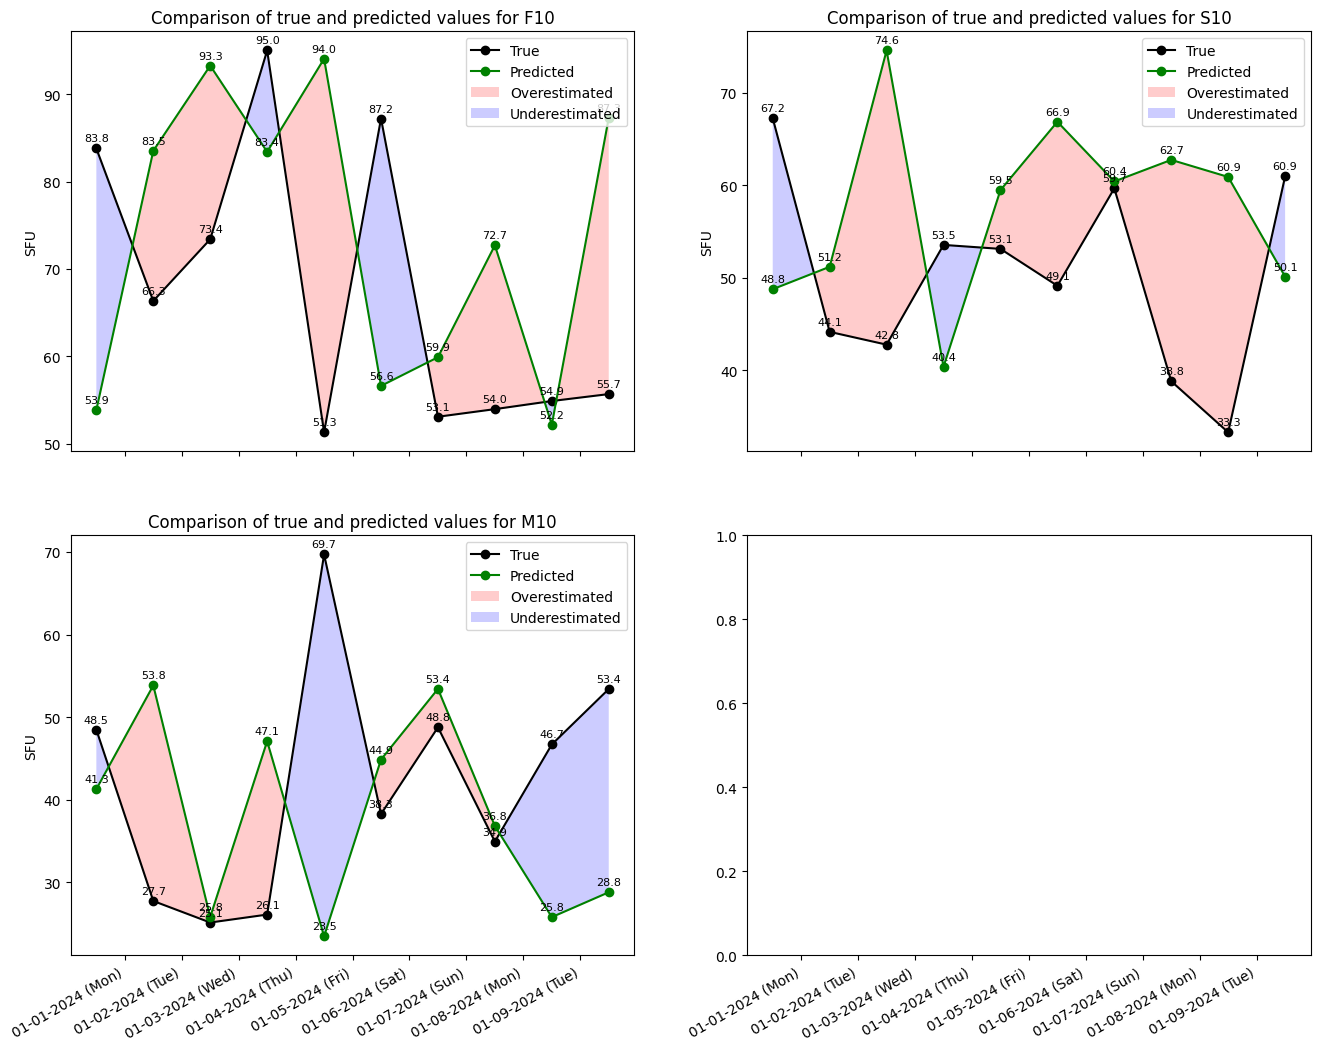

In [154]:
# Test

# Generate synthetic data for testing
dates = pd.date_range(start="2024-01-01", periods=10, freq="D")
true_values = {
    'Datetime': dates,
    'F10': np.random.uniform(50, 100, size=10),
    'S10': np.random.uniform(30, 80, size=10),
    'M10': np.random.uniform(20, 70, size=10),
}
preds_values = {
    'Datetime': dates,
    'F10': np.random.uniform(50, 100, size=10) + np.random.uniform(-5, 5, size=10),
    'S10': np.random.uniform(30, 80, size=10) + np.random.uniform(-5, 5, size=10),
    'M10': np.random.uniform(20, 70, size=10) + np.random.uniform(-5, 5, size=10),
}

true_df = pd.DataFrame(true_values)
preds_df = pd.DataFrame(preds_values)

# Call the plotting function
plot_predictions_performance(true_df, preds_df, data_columns=['F10', 'S10', 'M10'])


## Predictions Performance - General View

This plot is a bit more complex that the one before. First of all, a special data generation is needed in order to create  correctly shaped the predictions tensor to be plot. Thats is the purpose of the first function `prepare_tensor_to_forecast_histogram()`. Once this has been done the histogram could be plotted. This plot is better explained in the predictions notebook of `/dev_nbs/SolFSMY_10.7_Indices/solfsmy_preds`.

In [155]:
#|export
def prepare_tensor_to_forecast_histogram(df, model_data, start_date, end_date):
    measures_per_day = 24/((df.Datetime.iloc[1] - df.Datetime.iloc[0]).total_seconds() / 3600)

    lookback_days = model_data.lookback/measures_per_day
    horizon_days = model_data.horizon/measures_per_day
    start_date_forecast = pd.Timestamp(start_date - dt.timedelta(days=lookback_days+horizon_days))
    end_date_forecast = pd.Timestamp(end_date + dt.timedelta(days=horizon_days))

    X, _ = prepare_forecasting_data(df[(df.Datetime >= start_date_forecast) & (df.Datetime <= end_date_forecast)], 
                                    fcst_history=model_data.lookback, 
                                    fcst_horizon=model_data.horizon,
                                    x_vars=model_data.data_columns, 
                                    y_vars=model_data.data_columns)


    X_tensor = torch.from_numpy(X).float().cuda()

    return X_tensor

In [156]:
#| export
def plot_histogram_with_accuracy_preds(true_df:pd.DataFrame, preds:torch.Tensor, data_columns:list):
    steps, _, horizon = preds.shape    
    is_daily_data = pd.infer_freq(true_df.Datetime) == 'D'

    for idx, data_column in enumerate(data_columns):
        # Heatmap data with shape (horizon+lookback.length, horizon.length)
        pred_matrix = np.zeros((steps-horizon,horizon))

        for i in range(horizon,(steps-horizon)+horizon):
            for j in range(horizon): # 3 days
                pred_matrix[i-horizon,j] = preds[i-j, idx, j].cpu().numpy()

        heatmap_data = pred_matrix[1:,:] - true_df[data_column].values.reshape((steps-horizon)-1,1)

        # heatmap_data = (preds.cpu() - y)[:,0]

        # Line plot data
        values = true_df[data_column]
        dates = true_df['Datetime']

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Transpose heatmap data for imshow (so it matches the orientation of dates x forecast_periods)
        heatmap_data = heatmap_data.T

        # Create the heatmap
        cax = ax1.imshow(heatmap_data, extent=[dates.iloc[0], dates.iloc[-1], horizon, 1],
                        aspect='auto', cmap='RdBu_r', vmin=-300, vmax=400)

        # Create colorbar
        cbar = fig.colorbar(cax, ax=ax1)
        cbar.set_label('$\Delta_{ ' + data_column + '}$')

        # Set labels for the heatmap
        ax1.set_xlabel('Datetime')
        ax1.set_ylabel('Forecast Period (3 hours)' if not is_daily_data else 'Daily Forecast Period')
        ax1.set_title(f'Forecasts Performance of {data_column}')

        # Customize x-axis ticks
        ax1.xaxis.set_major_locator(mdates.DayLocator())
        ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=3)) if not is_daily_data else None
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M')) if not is_daily_data else None

        ax1.tick_params(axis='x', which='major', labelsize=10)
        ax1.tick_params(axis='x', which='minor', labelsize=8, rotation=90)
        plt.setp(ax1.get_xticklabels(), rotation=90)

        # Create a second y-axis for the line plot
        ax2 = ax1.twinx()
        ax2.plot(dates, values, color='k', linewidth=1.5)

        # Set labels for the line plot
        ax2.set_ylabel(f'Real values of {data_column} [sfu]', color='k')
        ax2.tick_params(axis='y', labelcolor='k')

        plt.show()



## $\LaTeX$ Formatting Functions

Here can be found some functions that are used around the repository to better format autogenerated $\LaTeX$ code.

In [157]:
#|export
def bold_best(X, X_ref, higher_better=False, bold_ref_too=False, 
              bold_equal=False, use_abs=False):
    """
        Returns X with the best values in bold, with respect to X_ref, position by
        position, i.e., if X[0] is better than X_ref[0] it will be bolded. 
        Input:
            X: 1D numpy array
            X_ref: 1D numpy array
            higher_better: If True, then the best values are the highest ones
            bold_ref_too: If True, best values in X_ref are also in bold.
            bold_equal: If bold_equal is True, then the values equal to the 
            best ones are also bolded
            use_abs: If True, then the absolute values are used to compare
        Output:
            X: 1D numpy array with the best values in bold (or a tuple of two
            1D numpy arrays if bold_ref_too is True)
    """
    if use_abs:
        X_abs = np.abs(X)
        X_ref_abs = np.abs(X_ref)
    else:
        X_abs = X
        X_ref_abs = X_ref
    if higher_better:
        if bold_equal:
            best = np.greater_equal(X_abs, X_ref_abs)
        else:
            best = np.greater(X_abs, X_ref_abs)
    else:
        if bold_equal:
            best = np.less_equal(X_abs, X_ref_abs)
        else:
            best = np.less(X_abs, X_ref_abs)
    # Make bold
    X = np.array([f'\\textbf{{{x}}}' if best[i] else f'{x}' for i, x in enumerate(X_abs)])
    if bold_ref_too:
        X_ref = np.array([f'\\textbf{{{x}}}' if not best[i] else f'{x}' for i, x in enumerate(X_ref_abs)])
        return X, X_ref
    else:
        return X

In [158]:
# Test
X = np.array([1, 2, 3, 4, 5])
X_ref = np.array([5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, bold_equal=True)
test_eq(res, (np.array(['1', '2', '\\textbf{3}', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=False, bold_ref_too=False)
test_eq(res, (np.array(['\\textbf{1}', '\\textbf{2}', '3', '4', '5'])))

# TODO: Bold 3? 
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}']),
                np.array(['\\textbf{5}', '\\textbf{4}', '\\textbf{3}', '2', '1'])))

# Test use_abs
X = np.array([-1, 2, 3, 4, 5])
X_ref = np.array([-5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=False)
test_eq(res, (np.array(['\\textbf{-1}', '2', '3', '\\textbf{4}', '\\textbf{5}'])))



In [159]:
#|export
def _highlight_better_values(df, our_col, paper_col, stat):
    return np.where(
        np.abs(df[our_col][stat]) < np.abs(df[paper_col][stat]),
        '\\textbf{' + df[our_col][stat].astype(str) + '}',
        df[our_col][stat].astype(str)
    )

def create_latex_comparison_tables(results_df, forecast_variables, forecast_horizon):
    """
    Generates LaTeX tables comparing our model's forecast results with a reference paper.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing 'variable', 'condition', 'horizon', 'statistic', 'value_ours', 'value_paper'.
    - forecast_variables (list of str): List of forecast variables to include.
    - forecast_horizon (int): Number of forecast days.

    Example:
    create_comparison_tables(results_df, ['var1', 'var2'], 1)
    """
    reshaped_df = results_df.pivot_table(
        index=['variable', 'condition', 'horizon'],
        columns='statistic',
        values=['value_ours', 'value_paper']
    )

    # Highlight better mean and std values
    reshaped_df[('value_ours', 'mean_str')] = _highlight_better_values(reshaped_df, 'value_ours', 'value_paper', 'mean')
    reshaped_df[('value_ours', 'std_str')] = _highlight_better_values(reshaped_df, 'value_ours', 'value_paper', 'std')
    reshaped_df[('value_paper', 'mean_str')] = _highlight_better_values(reshaped_df, 'value_paper', 'value_ours', 'mean')
    reshaped_df[('value_paper', 'std_str')] = _highlight_better_values(reshaped_df, 'value_paper', 'value_ours', 'std')

    # Drop the original mean and std columns
    reshaped_df = reshaped_df.drop(columns=[('value_ours', 'mean'), ('value_ours', 'std'),
                                            ('value_paper', 'mean'), ('value_paper', 'std')])

    # Combine mean and std into a single column
    reshaped_df[('value_ours', 'mean ± std')] = reshaped_df[('value_ours', 'mean_str')] + ' ± ' + reshaped_df[('value_ours', 'std_str')]
    reshaped_df[('value_paper', 'mean ± std')] = reshaped_df[('value_paper', 'mean_str')] + ' ± ' + reshaped_df[('value_paper', 'std_str')]

    # Drop the intermediate string columns
    reshaped_df = reshaped_df.drop(columns=[('value_ours', 'mean_str'), ('value_ours', 'std_str'),
                                            ('value_paper', 'mean_str'), ('value_paper', 'std_str')])

    # Clean up column levels
    reshaped_df.columns = reshaped_df.columns.droplevel(0)
    reshaped_df.columns = ['NN', 'benchmark']
    reshaped_df = reshaped_df.reset_index()

    # Sort conditions
    reshaped_df['condition'] = pd.Categorical(reshaped_df['condition'], categories=['low', 'moderate', 'elevated', 'high'], ordered=True)
    reshaped_df = reshaped_df.sort_values(by=['variable', 'condition'])

    # Print LaTeX tables for each variable
    for variable in forecast_variables:
        variable_df = reshaped_df[reshaped_df['variable'] == variable].drop(columns='variable')
        latex_table = variable_df.to_latex(
            index=False, 
            escape=False,
            column_format='|l|' + '|c|' * forecast_horizon,
            caption=f'Comparison of the results of the paper with the results of our model for the variable {variable}',
            label=f'tab:comparison_{variable}'
        )
        print(latex_table)

In [160]:
# Test

# Sample data to test the function
data = {
    'variable': ['var1', 'var1', 'var1', 'var1', 'var2', 'var2', 'var2', 'var2'],
    'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
    'horizon': [1, 1, 1, 1, 1, 1, 1, 1],
    'statistic': ['mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean'],
    'value_ours': [1.0, 2.0, 3.0, 4.0, 2.0, 2.5, 3.5, 4.5],
    'value_paper': [1.5, 2.5, 2.5, 3.5, 2.5, 2.0, 4.0, 3.5]
}

df_results_joined = pd.DataFrame(data)

# Include standard deviations as another statistic
df_results_joined_std = df_results_joined.copy()
df_results_joined_std['statistic'] = 'std'
df_results_joined_std['value_ours'] = df_results_joined_std['value_ours'] * 0.1
df_results_joined_std['value_paper'] = df_results_joined_std['value_paper'] * 0.2

# Combine mean and std dataframes
df_results_joined = pd.concat([df_results_joined, df_results_joined_std])

# Define the forecast variables and horizon
forecast_variables = ['var1', 'var2']
forecast_horizon = 1

# Run the function
create_latex_comparison_tables(df_results_joined, forecast_variables, forecast_horizon)

\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable var1}
\label{tab:comparison_var1}
\begin{tabular}{|l||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & \textbf{1.0} ± \textbf{0.1} & 1.5 ± 0.30000000000000004 \\
moderate & 1 & \textbf{2.0} ± \textbf{0.2} & 2.5 ± 0.5 \\
elevated & 1 & 3.0 ± \textbf{0.30000000000000004} & \textbf{2.5} ± 0.5 \\
high & 1 & 4.0 ± \textbf{0.4} & \textbf{3.5} ± 0.7000000000000001 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable var2}
\label{tab:comparison_var2}
\begin{tabular}{|l||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & \textbf{2.0} ± \textbf{0.2} & 2.5 ± 0.5 \\
moderate & 1 & 2.5 ± \textbf{0.25} & \textbf{2.0} ± 0.4 \\
elevated & 1 & \textbf{3.5} ± \textbf{0.35000000000000003} & 4.0 ± 0.8 \\
high & 1 & 4.5 ± \textbf{0.45} & \textbf{3.5} ± 0.70000

In [161]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()